# Generative SMILES Model: Details

This Jupyter notebook accompanies the generative SMILES model codebase adapted from `REINVENT`. See the following publications for details on `REINVENT`:

* https://jcheminf.biomedcentral.com/articles/10.1186/s13321-017-0235-x 

* https://pubs.acs.org/doi/full/10.1021/acscentsci.7b00512

* https://pubs.acs.org/doi/10.1021/acs.jcim.0c00915

The content here is an attempt to breakdown how each component of the generative SMILES model comes together. 

In [1]:
import re
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

import warnings
# ignore some deprecation warnings
warnings.filterwarnings('ignore')

## SMILES Vocabulary: How is it generated?

The model's `Vocabulary` handles the transformation of SMILES strings into a sequence of tokens. Tokens are the pre-defined lowest and indivisible unit of string text. In `Natural Language Processing (NLP)`, tokens are typically defined on the word or character level. The level of tokenization dictates ***what*** the model can output, e.g., if tokenization on the character level is used, then the model outputs individual characters. 

For generative SMILES models, tokenization is performed on the character level where each token ***loosely*** maps to a unique atom type (brackets, "(" for example indicate branching and thus, do not map to an atom but rather gives connectivity information).

In [2]:
from smiles_lstm.model.smiles_vocabulary import Vocabulary, SMILESTokenizer

Let's first explore how SMILES strings are tokenized which constitutes **Data Preparation** and is thus the first step in training our generative SMILES model. The most important part of the code are the ***rules*** denoting ***how*** to tokenize the SMILES. It is based on **regular expressions (regexp)** which perform pattern matching. The code below is from the `SMILESTokenizer` class.

In [3]:
REGEXPS = {
        "brackets": re.compile(r"(\[[^\]]*\])"),
        "2_ring_nums": re.compile(r"(%\d{2})"),
        "brcl": re.compile(r"(Br|Cl)")
    }
REGEXP_ORDER = ["brackets", "2_ring_nums", "brcl"]

def tokenize(data, with_begin_and_end=True):
    """Tokenizes a SMILES string."""
    def split_by(data, regexps):
        if not regexps:
            return list(data)
        regexp = REGEXPS[regexps[0]]
        splitted = regexp.split(data)
        tokens = []
        for i, split in enumerate(splitted):
            if i % 2 == 0:
                tokens += split_by(split, regexps[1:])
            else:
                tokens.append(split)
        return tokens

    tokens = split_by(data, REGEXP_ORDER)
    
    # if true, the token set is enriched by "^" and "$" denoting the start and end of the embedding, respectively
    if with_begin_and_end:
        tokens = ["^"] + tokens + ["$"]
    return tokens

The **REGEXPS** variable holds the patterns in which the SMILES are to be tokenized. Let's illustrate each pattern and the chemistry rationale. Below is a visual of the **"brackets"** pattern (*generated using debuggex*):

<div>
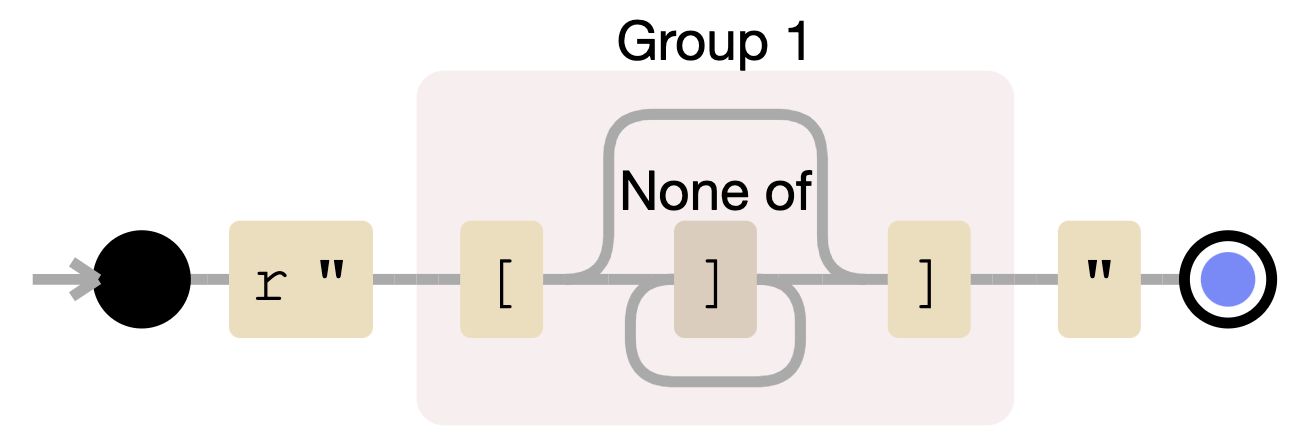
</div>

This regexp pattern groups characters within square brackets together which can represent charged atoms in the SMILES syntax. This is relevant in chemistry for example with positively charged nitrogen atoms:

<div>
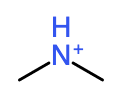
</div>

Let's now tokenize the SMILES.

In [4]:
charged_nitrogen_smiles = 'C[NH+]C'
# [NH+] is its own token which means it is part of the generative model's vocabulary
# therefore, the generative model will learn to output positively charged nitrogen atoms
# the "with_begin_and_end" boolean denotes whether to add a "start" and "end" token to the tokenized SMILES. 
# it is set to false here to strictly illustrate tokenization of only the SMILES itself
print(tokenize(charged_nitrogen_smiles, with_begin_and_end=False))

['C', '[NH+]', 'C']


Let's perform the same illustration for the other 2 regexp patterns. Below is a visual of the "2_ring_nums" pattern:

<div>
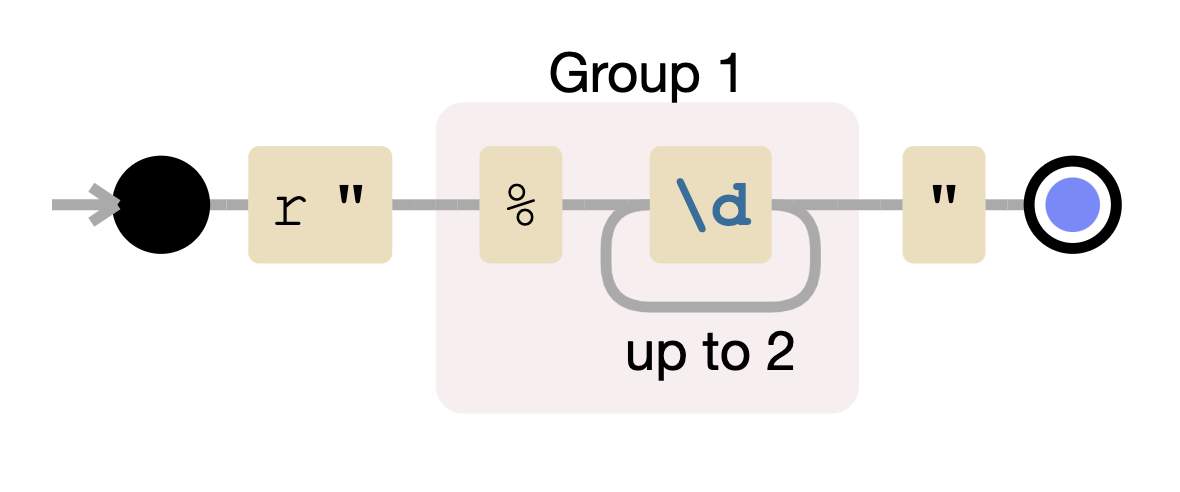
</div>

"Numbers" in SMILES strings can indicate either explicit hydrogens or ring closing. This is relevant in chemistry for example with explicit hydrogens such as "CH3" which would indicate there are 3 hydrogens attached to the carbon. Typically, however, hydrogens are implicitly expressed. This regex pattern is related to ring numbering and closing. Rings are distinguished by numbering. For molecules with over 10 rings, the percent ("%") symbol is used, e.g. "%10" means the tenth ring in the molecule. **This regex pattern matches "numbers" up to 2 digits**, for example, a molecule with 10 rings. As an extreme example (and as an excuse to use one of my favourite molecules), below is the structure of buckminsterfullerene or "bucky ball":

<div>
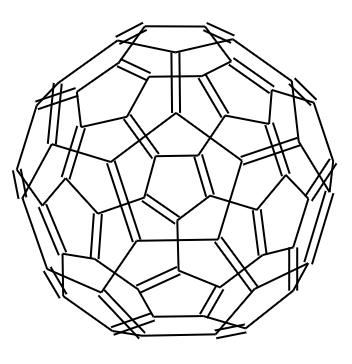
</div>

In [5]:
# notice the numbers in the smiles
bucky_ball_smiles = 'C12=C3C4=C5C6=C1C7=C8C9=C1C%10=C%11C(=C29)C3=C2C3=C4C4=C5C5=C9C6=C7C6=C7C8=C1C1=C8C%10=C%10C%11=C2C2=C3C3=C4C4=C5C5=C%11C%12=C(C6=C95)C7=C1C1=C%12C5=C%11C4=C3C3=C5C(=C81)C%10=C23'

# the tokenized form has many "double digit" numbers which are their own individual tokens
print(tokenize(bucky_ball_smiles, with_begin_and_end=False))

['C', '1', '2', '=', 'C', '3', 'C', '4', '=', 'C', '5', 'C', '6', '=', 'C', '1', 'C', '7', '=', 'C', '8', 'C', '9', '=', 'C', '1', 'C', '%10', '=', 'C', '%11', 'C', '(', '=', 'C', '2', '9', ')', 'C', '3', '=', 'C', '2', 'C', '3', '=', 'C', '4', 'C', '4', '=', 'C', '5', 'C', '5', '=', 'C', '9', 'C', '6', '=', 'C', '7', 'C', '6', '=', 'C', '7', 'C', '8', '=', 'C', '1', 'C', '1', '=', 'C', '8', 'C', '%10', '=', 'C', '%10', 'C', '%11', '=', 'C', '2', 'C', '2', '=', 'C', '3', 'C', '3', '=', 'C', '4', 'C', '4', '=', 'C', '5', 'C', '5', '=', 'C', '%11', 'C', '%12', '=', 'C', '(', 'C', '6', '=', 'C', '9', '5', ')', 'C', '7', '=', 'C', '1', 'C', '1', '=', 'C', '%12', 'C', '5', '=', 'C', '%11', 'C', '4', '=', 'C', '3', 'C', '3', '=', 'C', '5', 'C', '(', '=', 'C', '8', '1', ')', 'C', '%10', '=', 'C', '2', '3']


A quick note is that such large molecules are typically removed from the training data as they are far too large to be reasonable drug molecules (there are of course exceptions).

The last regex pattern is "brcl":

<div>
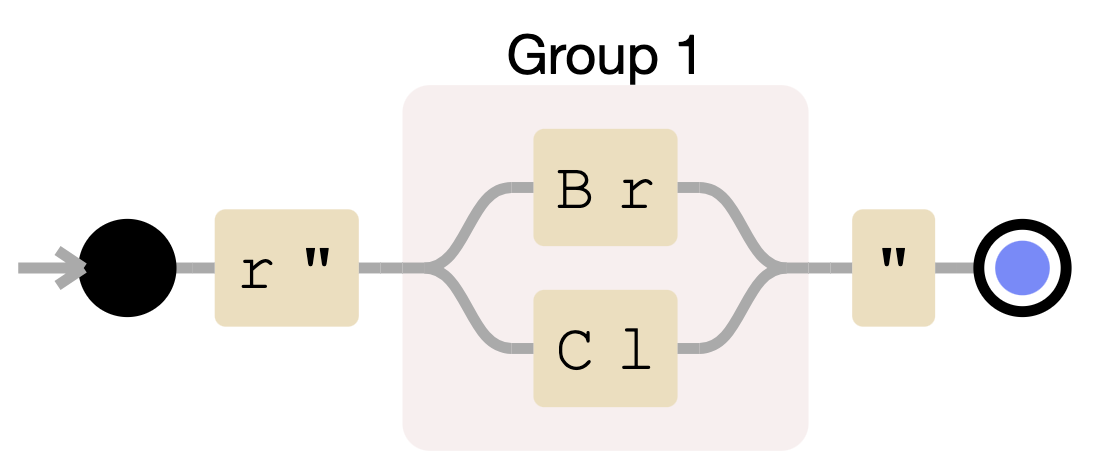
</div>

This regexp pattern simply matches bromine and chlorine ("Br" and "Cl") and ensures they are their own unique token. These halogen atoms are quintessential in drug molecules. Below is an example of a molecule containing bromine (bromoethane):

<div>
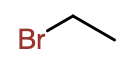
</div>

In [6]:
bromoethane_smiles = 'CCBr'
# as expected "Br" is its own token
print(tokenize(bromoethane_smiles, with_begin_and_end=False))

['C', 'C', 'Br']


## Constructing the Generative Model's SMILES Vocabulary

The previous section focused on how a SMILES string is tokenized. In order to use these tokenized SMILES, we must create the `Vocabulary`. Much like in a natural language like english where one's vocabulary controls what sentences can be formulated, a molecular generative model's vocabulary controls what kind of atoms can be proposed - sentences in this context are molecules. 

The below method is in `vocabulary.py`.

In [7]:
def create_vocabulary(smiles_list, tokenizer):
    """Creates a vocabulary for the SMILES syntax."""
    tokens = set()
    for smi in smiles_list:
        tokens.update(tokenize(data=smi, with_begin_and_end=False))

    vocabulary = Vocabulary()
    vocabulary.update(["$", "^"] + sorted(tokens))  # end token is 0 (also counts as padding)
    return vocabulary

In [8]:
# example dataset containing the 3 molecules from the previous section
# notice the "bucky ball" was included. It is not a reasonable drug molecule but it is included
# here to illustrate a consequence of having exceptionally large molecules in your dataset
smiles_dataset = ['C[NH+](C)C',
                  'C12=C3C4=C5C6=C1C7=C8C9=C1C%10=C%11C(=C29)C3=C2C3=C4C4=C5C5=C9C6=C7C6=C7C8=C1C1=C8C%10=C%10C%11=C2C2=C3C3=C4C4=C5C5=C%11C%12=C(C6=C95)C7=C1C1=C%12C5=C%11C4=C3C3=C5C(=C81)C%10=C23',
                  'CCBr'
                 ]

vocabulary = create_vocabulary(smiles_list=smiles_dataset, tokenizer=SMILESTokenizer)


We've now created a `Vocabulary` object using the example SMILES dataset. Let's take a closer look:

In [9]:
print(f'There are {len(vocabulary)} unique tokens in the vocabulary.\n')
print(f'The unique tokens are: \n{vocabulary.tokens()}')

There are 20 unique tokens in the vocabulary.

The unique tokens are: 
['$', '^', '%10', '%11', '%12', '(', ')', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'Br', 'C', '[NH+]']


A `Vocabulary` containing 20 tokens means the generative model will be able to output 20 tokens. The specific tokens are shown above. The "bucky ball" was included in the example dataset to show that exceptionally large molecules may contain **"rare" tokens which make the vocabulary larger**. In addition to the "bucky ball" not being a type of molecule we would typically want to generate (it is not very "drug-like"), the **"rare" tokens** such as "%10" are rare because typical drug molecules would not contain these tokens. 


**The important consequence is that a larger vocabulary makes the generative model slower. This could be acceptable if we indeed want to generate exceptionally large molecules. However, for drug discovery, such molecules are often removed from the dataset for 2 reasons:**

1) Ensures all SMILES in the dataset are reasonable ("drug-likeness"). This affects the "type" of molecules the generative model outputs as ***the goal when training the generative model is to learn the underlying probability distribution of the dataset.*** This will be elaborated in the model details section.

2) Eliminate "rare" tokens that slow the model down. "Rare" tokens are tokens with very few occurrences in the training set. The details into why this slows the model will be elaborated in the model details section.

Finally, in order for the token representations of SMILES sequences to be passed into a machine learning model, they must be transformed into a numerical representation. This is done in the `Vocabulary` class where each unique token is mapped to a numerical index. This is shown below:

In [10]:
# bromoethane has the SMILES sequence "CCBr"
bromoethane_smiles = 'CCBr'
# recall its tokenized form
tokenized_bromoethane = tokenize(bromoethane_smiles, with_begin_and_end=False)
tokenized_bromoethane

['C', 'C', 'Br']

Cross-referencing the unique tokens list above, we can see that "Br" and "C" are located at indices 17 and 18, respectively. Let's show this:

In [11]:
# the "encode" method in the Vocabulary class takes a list of tokens and returns its numerical indices
# the indices are what we expect
vocabulary.encode(tokenized_bromoethane)

array([18., 18., 17.], dtype=float32)

Exactly ***how*** this numerical representation is used in the generative model will be elaborated in the `RNN Sampling: Step-by-Step` section. Let's first discuss what a Recurrent Neural Network using SMILES means.

## What is a Recurrent Neural Network (RNN) using SMILES?

The molecular generative model uses a Recurrent Neural Network (RNN) ***which is tasked to learn the underlying probability distribution of the SMILES sequences in the dataset.*** The following section attempts to deconvolute what this exactly means.

### High Level Idea
* We want our model to be able to generate **valid** SMILES. Valid SMILES are those that can be parsed successfully and transformed into a 2D molecular representation (for example, through RDKit which is a Python cheminformatics library)


* **Goal**: Teach the RNN the SMILES syntax via the following steps:

1) Create a SMILES dataset (training data). Open-source databases like ChEMBL (https://www.ebi.ac.uk/chembl/) and ZINC (https://zinc.docking.org/) curate large collections of "drug-like" molecules

2) The SMILES dataset will be passed to the RNN and the task is for the RNN to **reproduce** these SMILES

**Note:** This is what learning the underlying probability distribution of the SMILES sequences in the training set means. The RNN outputs 1 token at a time and successfully reproducing the training set SMILES teaches the model the SMILES syntax. By contrast, an untrained RNN would just output random sequences of tokens with no chemical meaning.

As a concrete example (also the example given by Marwin Segler in the following publication: https://pubs.acs.org/doi/full/10.1021/acscentsci.7b00512), consider the model has produced the following sequence thus far:

**c1ccccc**

The next token the model outputs has high probability of being **"1"**, yielding the sequence:

**c1ccccc1**

This SMILES string corresponds to benzene:

<div>
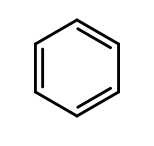
</div>

Benzene is ubiquitous in bioactive molecules and predicting the next token to be **"1"** closes the benzene ring and gives some notion that the model has learned ***conditional-dependence***. Specifically, the model's prediction of the next token ***should*** take into account the sequence of tokens observed ***thus far***. After all, the sequence observed thus far could perhaps give *hints* into what the "correct" (in the context of what SMILES is to be reproduced) next token is. This will be formalized in the next section.

### Formal Problem Set-up

The probability of generating a particular SMILES sequence is given by:

$$P_\theta(S) = P_\theta(s_1) * \prod_{t = 2}^{T} P_\theta(s_t|s_{t-1}, s_{t-2},...,s_1)$$

where $S$ is a SMILES sequence, $s_t$ are the tokens, and $\theta$ are the traininable parameters of the model. The expression above states that generating a particular SMILES sequence is the product sum of the ***conditional probabilities*** of generating the 1st token, then generating the 2nd token ***given*** the 1st token, then generating the 3rd token ***given*** the 1st and 2nd token, etc. 

A RNN is used because they use ***hidden state matrices*** to keep track of the tokens generated thus far. This allows the RNN to model ***conditional-dependence***. A detailed description of RNNs is omitted here but a few key equations are shown below to further highlight how ***conditional-dependence*** is modelled.

Normal feed-foward neural networks (FFNNs) perform the following operations:

$$H = \phi(XW_1 + b_1)$$

$$Output = HW_2 + b_2$$

where $\phi$ is the activation function, $X$ is the input matrix, $W_1$ is the weight matrix, and $b_1$ is the bias. The first equation details the hidden layer computation where the result is then used to compute the final output.

By contrast, RNNs perform the following operations:

$$H_t = \phi(X_tW_{input} + H_{t-1}W_{hidden} + b_1)$$

$$Output = H_tW_{output} + b_2$$

In contrast to FFNNs, RNNs contain an extra term, $H_{t-1}$. Each time the RNN generates a token is defined as a time-step. The first equation states that the computation of the hidden layer of the current time-step, $H_t$ depends on the **hidden state** from the previous time-step, $H_{t-1}$. In this way, RNNs model ***conditional-dependence***.

**Note**: The specific type of recurrent cells used is called `Long Short-Term Memory (LSTM)` which perform a different computation than shown above (more complex but still involving the **hidden state** from the previous time-step). The key information I wanted to convey is that explicit treatment of $H_{t-1}$ keeps track of the token sequence observed thus far. For more information including the equations involved in LSTM cells, see the original publication: https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.676.4320&rep=rep1&type=pdf

Finally, the output of the RNN (which token to sample next) is a ***multinomial probability distribution*** over the entire `Vocabulary`, i.e., the conditional probabilities of all the possible tokens. This will be shown in the next section.


## RNN Sampling: Step-by-Step 

The RNN sampling proceeds via the following steps:

1) Obtain the token embedding vector

2) Pass the embedding vector into the RNN

3) Output the softmax conditional probability

Let's go through each step.

### Embedding

This section describes ***how*** the numerical representation of tokens are transformed into an input vector known as the embedding that will act as the input to the RNN.

In [12]:
# bromoethane has the SMILES sequence "CCBr"
bromoethane_smiles = 'CCBr'
# recall its tokenized form
tokenized_bromoethane = tokenize(bromoethane_smiles, with_begin_and_end=False)
tokenized_bromoethane

['C', 'C', 'Br']

In [13]:
# construct an "Embedding layer"
embedding_layer = nn.Embedding(num_embeddings=20,
                               embedding_dim=5)

# show the embedding vectors
# note the vectors at indices 17 and 18 (3rd last and 2nd last): they will be cross-referenced 3 cells down
print(embedding_layer.weight)

Parameter containing:
tensor([[-2.5148e-01,  1.0521e+00, -1.5166e+00, -2.5020e-02, -2.3802e-01],
        [-9.4439e-01,  1.3609e+00, -5.4443e-02, -4.1294e-02,  9.3988e-01],
        [-2.9158e-01,  1.7753e-01,  1.4038e+00, -1.0818e+00,  9.8024e-01],
        [ 1.1290e+00,  2.6271e-01, -1.0208e+00,  4.3664e-01,  8.4404e-01],
        [ 8.5915e-01,  7.4262e-01,  1.1333e+00,  1.5831e+00, -1.4052e+00],
        [ 4.6615e-01,  7.3996e-01, -1.9790e-01,  1.9419e+00, -1.3770e+00],
        [ 5.2195e-01, -3.9826e-01, -2.5036e+00,  1.6919e+00,  1.3590e-01],
        [-1.6141e+00, -3.1559e-01, -4.5956e-01, -8.4103e-02, -4.4971e-01],
        [ 5.8646e-01,  3.6788e-01,  2.4224e+00,  1.9125e+00,  8.0887e-01],
        [-2.0546e-01, -4.7794e-01,  1.2680e+00, -3.3695e-01, -2.8962e-01],
        [-1.4349e-01, -7.7586e-02, -1.5830e+00,  1.6790e+00, -1.5794e+00],
        [-3.9287e-01, -1.2366e+00, -7.9615e-02,  2.1058e-01, -1.0041e+00],
        [-2.8490e+00,  5.2780e-01,  1.0786e+00, -4.5372e-01,  1.1849e+00],
   

An `Embedding Layer` is essentially a look-up table. In the constructor above, `"num_embeddings"` refers to the `Vocabulary` size. In our case, the example `Vocabulary` has a size of 20:

In [14]:
# recall the example Vocabulary
print(f'There are {len(vocabulary)} unique tokens in the vocabulary.\n')
print(f'The unique tokens are: \n{vocabulary.tokens()}')

There are 20 unique tokens in the vocabulary.

The unique tokens are: 
['$', '^', '%10', '%11', '%12', '(', ')', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'Br', 'C', '[NH+]']


`"num_embeddings"` denotes how many vectors to initialize. Since we have 20 unique tokens, we need 20 different vectors: 1 for each unique token. This is why `"num_embeddings"` is 20 in this example. `"embedding_dim"` denotes the dimension of the embedding vector. 5 is arbitrarily chosen here just for easy visualization.

In [15]:
# get the numerical indices of bromoethane
numerical_indices_bromoethane = torch.LongTensor([vocabulary.encode(tokenized_bromoethane)])
print(f"Numerical indices of bromoethane:\n {numerical_indices_bromoethane}\n")

embedding = embedding_layer(numerical_indices_bromoethane)
print(f"Embedding:\n {embedding}")

Numerical indices of bromoethane:
 tensor([[18, 18, 17]])

Embedding:
 tensor([[[-1.6855, -0.6322, -2.0447,  1.0050, -0.2203],
         [-1.6855, -0.6322, -2.0447,  1.0050, -0.2203],
         [-0.0850,  2.4190,  1.6571, -0.1171, -0.7811]]],
       grad_fn=<EmbeddingBackward0>)


The `Embedding Layer` was defined to have 20 embedding vectors as denoted by `"num_embeddings"`. In the numerical indices of bromoethane, "C" is index 18 and "Br" is index 17. The `Embedding Layer` returns the embedding vector at indices 18 and 17. Cross-referencing the output embedding tensor, we can see that the first two rows are identical (as they should be) and corresponding to the first 2 "C" tokens. The last token is "Br" with a numerical index of 17 and thus differs. Cross-referencing the embedding vectors 3 cells above, we can see that the embedding is indeed the same as the vectors at indices 17 and 18.


Finally, the dimension of each embedding vector is 5 as denoted by `"embedding_dim"`.

**Note**: The `Embedding Layer` is initialized randomly so the actual embedding vectors are not meaningful yet. These vectors are updated through training of the RNN.

**Further Note**: Recall the inclusion of the "bucky ball" in our example SMILES dataset. It was previously mentioned that "rare" tokens make the `Vocabulary` larger which may not be desirable. Here, we can see that a larger `Vocabulary` would require a larger `"num_embeddings"`. When training the RNN, backpropagation would have to update more parameters and thus, the RNN requires more computations. A further consequence of having more parameters is GPU memory (typically, GPUs are used for vector computations). If there is insufficient memory, smaller training batches would have to be used which would then increase the model training time.

### Recurrent Layers

The `Embedding Layer` generates the input vector to be passed to the `Recurrent Layers` which perform the "recurrent" computation as shown in the `Formal Problem Set-up` section.

Below is code that initializes a `Recurrent Layer` using `Long Short-Term Memory (LSTM)` cells which has demonstrated extensive success in `Natural Language Processing (NLP)` tasks. See the original publication for details on `LSTM`: https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.676.4320&rep=rep1&type=pdf

In [16]:
# only 1 layer of LSTM cells is initialized here for the sake of illustration
# input_size = 5 because we previously defined the "embedding_dim" of the Embedding layer to be 5
# hidden_size = 5 is arbitrarily chosen for easy visualization
recurrent_layer = nn.LSTM(input_size=5,
                          hidden_size=5,
                          num_layers=1,
                          dropout=0,
                          batch_first=True)

# recall the shape of our embedded SMILES sequence (this is our input to the recurrent layer)
# the shape is: (batch size) x (sequence length) x (embedding dimension)
# batch size is 1 since we only pass in 1 SMILES sequence for the sake of illustration
embedding.shape

torch.Size([1, 3, 5])

In [17]:
# let's run the embedding through the recurrent layer
rnn_output, (hidden_state, cell_state) = recurrent_layer(embedding)

The RNN output is what will be passed further through our model. The hidden state and cell state both keep track of previous information, i.e., the observed token sequence so far. The details of each are related to the LSTM cell and are omitted here. 

Let's double check the dimensions of output to make sure it is correct.

In [18]:
# the shape should be (batch size) x (sequence length) x (embedding dimension) just like the embedding
print(rnn_output.shape)

rnn_output.shape == embedding.shape

torch.Size([1, 3, 5])


True

After the input has passed through the `Recurrent Layer` (in the actual model, there are 3 recurrent layers), it is passed through the final `Linear Layer`. The purpose of the `Linear Layer` is to transform the output from the `Recurrent Layer` which has dimensions:

(batch size) x (sequence length) x **(hidden size)** 

to

(batch size) x (sequence length) x **(vocabulary size)**

An output over the `Vocabulary` size means there will be 1 numerical quantity corresponding to each possible token in the `Vocabulary`. The purpose of this is for the final step where these numerical quantities are transformed into a "probability". ***There will be 1 probability associated with each token, representing how likely the model will propose each token in the next time step.***

Before discussing how the multinomial probability distribution (multinomial since the `Vocabulary` size is greater than 1), let's first show the output from the `Linear Layer`:

In [19]:
# initialize the linear layer
# in_features = 5 as that is the hidden_size defined in the recurrent layer above
# out_features = 20 as that is the size of the Vocabulary
linear_layer = nn.Linear(in_features=5,
                         out_features=20)

linear_output = linear_layer(rnn_output)

# verify the shape of the linear output is what we expect:
# (batch size) x (sequence length) x (vocabulary size)
linear_output.shape

torch.Size([1, 3, 20])

### Softmax: Obtaining a Multinomial Conditional Probability Distribution

At this point, we have a tensor that has dimensions **(batch size) x (sequence length) x (vocabulary size)**. The last step is to apply the `Softmax Function` to obtain a multinomial probability distribution which can be interpreted as the probability of generating each specific token at the next time step. To breakdown this step, let's first introduce the `Softmax Function`:

$$Softmax(token_i) = \frac{e^{token_i}}{\sum\limits_{j=1}^N e^{token_j}}$$

where $i$, $j = 1, 2, 3 ... N$ is the token index and $N$ corresponds to the last vocabulary token. The `Softmax Function` assigns each token probability a value between 0 and 1 (as all probabilities should be). Moreover, the sum of all token probabilities is 1, i.e., the probability of sampling *any* token must be 1.

**Problem: The `Softmax Function` can be numerically unstable whereby token probabilities can be assigned extremely small probabilities to the point of 0 or extremely large probabilities to the point of overflow (since we are taking $e$ to the exponent).**

Instead of using the `Softmax Function`, the `Log-Softmax Function` is used which outputs values $[-\infty, 0)$. This circumvents the numerical instabilities described above and importantly, retains the ***order*** of probability magnitudes, i.e., a lower probability outputted by The `Softmax Function` is also a lower probability from the `Log-Softmax Function` and vice versa. 


$$Log-Softmax(token_i) = \log(\frac{e^{token_i}}{\sum\limits_{j=1}^N e^{token_j}})$$


Let's take the output from the `Linear Layer` above and apply the `Log-Softmax Function`.

In [20]:
# let's first show the normal softmax output
# recall the output from the linear layer has dimensions: (batch size) x (sequence length) x (vocabulary size)
# therefore, dim=2 because we want to compute the softmax over the vocabulary to obtain a probability for each token
softmax = linear_output.softmax(dim=2)
print(softmax)

# the nice thing about softmax is that the sum of all probabilities equates to 1
print(softmax.sum(dim=2))

tensor([[[0.0572, 0.0401, 0.0313, 0.0308, 0.0520, 0.0247, 0.0412, 0.0580,
          0.0714, 0.0500, 0.0598, 0.0493, 0.0550, 0.0418, 0.0497, 0.0614,
          0.0663, 0.0419, 0.0574, 0.0608],
         [0.0556, 0.0432, 0.0306, 0.0309, 0.0507, 0.0231, 0.0397, 0.0579,
          0.0763, 0.0501, 0.0603, 0.0472, 0.0497, 0.0434, 0.0483, 0.0600,
          0.0684, 0.0425, 0.0585, 0.0637],
         [0.0596, 0.0382, 0.0318, 0.0291, 0.0542, 0.0270, 0.0362, 0.0579,
          0.0677, 0.0498, 0.0614, 0.0514, 0.0728, 0.0399, 0.0467, 0.0628,
          0.0681, 0.0358, 0.0539, 0.0558]]], grad_fn=<SoftmaxBackward0>)
tensor([[1.0000, 1.0000, 1.0000]], grad_fn=<SumBackward1>)


In [21]:
# let's now show the log-softmax output
log_softmax = linear_output.log_softmax(dim=2)
print(log_softmax)

# by contrast, the sum of the log-softmax output does not equate to 1
# since the log-softmax outputs values [-inf, 0)
print(log_softmax.sum(dim=2))

tensor([[[-2.8603, -3.2152, -3.4632, -3.4812, -2.9567, -3.7005, -3.1904,
          -2.8467, -2.6396, -2.9967, -2.8168, -3.0105, -2.9012, -3.1759,
          -3.0016, -2.7909, -2.7135, -3.1724, -2.8580, -2.7997],
         [-2.8890, -3.1412, -3.4874, -3.4756, -2.9827, -3.7697, -3.2274,
          -2.8497, -2.5736, -2.9947, -2.8084, -3.0525, -3.0017, -3.1362,
          -3.0306, -2.8142, -2.6821, -3.1584, -2.8385, -2.7536],
         [-2.8206, -3.2657, -3.4471, -3.5366, -2.9153, -3.6107, -3.3198,
          -2.8493, -2.6934, -2.9995, -2.7903, -2.9677, -2.6194, -3.2204,
          -3.0650, -2.7675, -2.6875, -3.3303, -2.9213, -2.8862]]],
       grad_fn=<LogSoftmaxBackward0>)
tensor([[-60.5910, -60.6671, -60.7134]], grad_fn=<SumBackward1>)


**Finally, how is the `Log-Softmax Function` output interpreted as token probabilities?**

Each tensor contains the probability of generating each token in the vocabulary at the next time step. Concretely:

In [22]:
# recall our original SMILES 
print(f"Original SMILES string: {bromoethane_smiles}\n")

# recall our vocabulary
print(f"The unique tokens are: \n{vocabulary.tokens()}\n")

# we now extract the max value in each tensor of the log-softmax output above and the corresponding token
most_probable_tokens = log_softmax.argmax(dim=2).flatten().tolist()
for idx, (correct_token, most_probable_token) in enumerate(zip(bromoethane_smiles, most_probable_tokens)):
    print(f"At time step {idx+1}, the generative model proposes {vocabulary.tokens()[most_probable_token]} as the most probable token and the correct token is {correct_token}")

Original SMILES string: CCBr

The unique tokens are: 
['$', '^', '%10', '%11', '%12', '(', ')', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'Br', 'C', '[NH+]']

At time step 1, the generative model proposes 2 as the most probable token and the correct token is C
At time step 2, the generative model proposes 2 as the most probable token and the correct token is C
At time step 3, the generative model proposes 6 as the most probable token and the correct token is B


**Cross-referencing the log-softmax output 2 cells above, notice the probability of each token is quite similar, i.e., the model thinks it is (roughly) equally likely to generate each token. This is because the model is untrained. Correspondingly, we see above that the model is quite poor at predicting the correct token.**

In summary, the steps of sampling the generative model are:

1. Tokenize the raw SMILES


2. Encode the vector (get the numerical vocabulary indices)



3. Collate the vector (pad the vector so that regardless of the length of SMILES strings passed into the model, the embedding vector has the same dimensions)


4. Generate the embedding (input vector)


5. Pass the embedding to the RNN


6. Apply a linear transformation on the RNN output so that the dimensions is equal to the vocabulary length


7. Apply log-softmax to obtain the multinomial token probability distribution

## How Does The Model Learn?

The previous section went through step-by-step how a raw SMILES string is passed through the entire model. The resulting multinomial probability distribution was not very useful as all tokens seemed to be equally likely of being proposed at the next time step. This section introduces the loss function, `Negative Log-Likelihood (NLL)` which we want to minimize.

$$NLL = \log(probability_{token})$$

Since the `Log-Softmax Function` already takes the $log$, the `Negative Log-Likelihood` simply takes the negative of the `Log-Softmax Function` output. 

Let's first see how this looks like through the corresponding tensors:

In [23]:
# define the loss
loss = torch.nn.NLLLoss(reduction='none')
# recall the correct token indices of "CCBr" which was our original SMILES
print(f"These are the token indices we would want our model to predict:\n{numerical_indices_bromoethane}\n")
print(f"Recall the log-softmax output:\n{log_softmax}\n")
print(f"We will transpose the log-softmax tensor to have shape (batch size) x (vocabulary) x (sequence length):\n{log_softmax.transpose(1,2)}\n")

print(f"The output tensor from negative log-likelihood is:\n{loss(log_softmax.transpose(1, 2), numerical_indices_bromoethane)}\n")

These are the token indices we would want our model to predict:
tensor([[18, 18, 17]])

Recall the log-softmax output:
tensor([[[-2.8603, -3.2152, -3.4632, -3.4812, -2.9567, -3.7005, -3.1904,
          -2.8467, -2.6396, -2.9967, -2.8168, -3.0105, -2.9012, -3.1759,
          -3.0016, -2.7909, -2.7135, -3.1724, -2.8580, -2.7997],
         [-2.8890, -3.1412, -3.4874, -3.4756, -2.9827, -3.7697, -3.2274,
          -2.8497, -2.5736, -2.9947, -2.8084, -3.0525, -3.0017, -3.1362,
          -3.0306, -2.8142, -2.6821, -3.1584, -2.8385, -2.7536],
         [-2.8206, -3.2657, -3.4471, -3.5366, -2.9153, -3.6107, -3.3198,
          -2.8493, -2.6934, -2.9995, -2.7903, -2.9677, -2.6194, -3.2204,
          -3.0650, -2.7675, -2.6875, -3.3303, -2.9213, -2.8862]]],
       grad_fn=<LogSoftmaxBackward0>)

We will transpose the log-softmax tensor to have shape (batch size) x (vocabulary) x (sequence length):
tensor([[[-2.8603, -2.8890, -2.8206],
         [-3.2152, -3.1412, -3.2657],
         [-3.4632, -3.4874,

The token index we wanted to predict at time step 1 was **18**. Cross-referencing the first column of the transposed log-softmax tensor at the 18th index (2nd last row), we see that the `Negative Log-Likelihood` simply takes the negative of the value. Similarly, at the last time step, we wanted to predict token index **17**. Cross-referencing the third column of the transposed log-softmax tensor at the 17th index (3rd last row), we see that the value is again the negative, as expected.

The `Negative Log-Likelihood` compares the token probabilities assigned by the model to the correct token indices. Recall that the `Log-Softmax Function` takes on values $[\infty$, 0). We would want our model to assign a high probability to the correct token. Therefore, training the model involves minimizing the `Negative Log-Likehood`.

Lastly, during backpropagation, we take the sum of the `Negative Log-Likehood` tensor to "summarize" the total loss associated with a given SMILES sequence:

In [24]:
loss(log_softmax.transpose(1, 2), numerical_indices_bromoethane).sum(dim=1)

tensor([9.0268], grad_fn=<SumBackward1>)

## What Does a Trained Model Look Like?

The previous section ended with showing how the loss function is calculated. Together with the observation that the untrained model assigns (rougly) equal probability of generating each token, this section quantitatively shows how a trained model may be expected to perform.

Recall that the **objective is to learn the underlying probability distribution of a SMILES dataset**. Here, we use the scripts available in the repository to download SMILES data from `ZINC` and to train a molecular generative model. The specific scripts used are: `01_download_data.py` and `02_train_model_locally.py`. The model was trained for 50 epochs using 50,000 SMILES strings. **Note that you should monitor the loss when training the molecular generative model such that it doesn't increase on the validation set (a sign of overfitting on the training set).** As the purpose of this section is to show ***how*** a trained model may be expected to perform, the model was somewhat arbitrarily trained for 50 epochs. The trained model is provided in the repository: `model.49.pth`.

In [25]:
# let's load the trained model
from smiles_lstm.model.smiles_lstm import SmilesLSTM

trained_model = SmilesLSTM(vocabulary=[1], tokenizer=None).load_from_file("model.49.pth")

# let's take a look at the vocabulary
print(f"There are {len(trained_model.vocabulary)} unique tokens:\n{trained_model.vocabulary.tokens()}")

There are 57 unique tokens:
['$', '^', '#', '(', ')', '-', '/', '1', '2', '3', '4', '5', '6', '7', '=', 'Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', '[C@@H]', '[C@@]', '[C@H]', '[C@]', '[CH-]', '[CH2-]', '[N+]', '[N-]', '[NH+]', '[NH-]', '[NH2+]', '[NH3+]', '[O-]', '[OH+]', '[P@@H]', '[P@@]', '[P@]', '[PH]', '[S+]', '[S-]', '[S@@]', '[S@]', '[SH+]', '[n+]', '[n-]', '[nH+]', '[nH]', '[o+]', '\\', 'c', 'n', 'o', 's']


The vocabulary is much bigger! There are quite a number of tokens that encode **Stereochemistry** and are present because the raw `ZINC` training data contains **Stereisomers**. In practice, this can add quite some complexity to the model and one may wish to remove instances of **Stereoisomers** before training a molecular generative model. Here, we omit any dataset filtering as the goal is just to show how this trained model performs.

Let's now use the same example proposed earlier about generating benzene with SMILES sequence:

**c1ccccc1**

Given a SMILES sequence of:

**c1ccccc**

a trained model should assign high probability to the **"1"** token to close out the benzene ring.

Let's show this:

In [26]:
# import Dataset to use its collate_fn method
from smiles_lstm.model.smiles_dataset import Dataset

benzene = 'c1ccccc'
# tokenize
benzene_tokenized = tokenize(benzene)
# encode (obtain numerical token indices)
benzene_encoded = trained_model.vocabulary.encode(benzene_tokenized)
# transform it into a tensor for collating
benzene_encoded = torch.tensor([benzene_encoded])
# collate
benzene_collated = Dataset.collate_fn(benzene_encoded)

In [27]:
# pass the collated tensor to the trained model
logits, _ = trained_model.network(benzene_collated[:, :-1])
log_probs = logits.log_softmax(dim=2)
# let's isolate the probability distribution of the last token in the incomplete benzene sequence
log_probs[0][7]

tensor([-14.2435, -13.5502, -13.2694,  -2.2387, -16.8499, -12.3029, -11.7999,
         -0.1184,  -5.4217,  -9.4808, -11.5950, -11.6601, -13.1247, -13.4469,
        -13.0427, -15.8290, -11.8195, -15.7927, -17.0695, -13.9670, -10.1932,
        -14.0092, -12.4640, -12.1874, -12.5263, -13.0197, -12.2085, -12.7578,
        -13.4579, -14.7750, -14.9601, -13.7766, -13.5119, -13.4318, -12.9227,
        -15.2083, -16.5822, -13.4793, -13.9786, -14.1714, -14.1127, -14.9476,
        -13.7649, -14.6333, -13.5755, -13.8157, -14.3851, -12.2122, -13.7716,
        -12.1530, -13.1898, -13.7298, -14.4979,  -7.7511, -10.8087, -13.5854,
        -13.7679], grad_fn=<SelectBackward0>)

The interpretation of the tensor above is: **The token probabilities given observing the sequence c1ccccc thus far**

A stark contrast from the previously untrained model is that there are different values assigned to tokens now. We are interested in finding the most probable token (based on having the highest probability):

In [28]:
# extract the index of the highest probability
highest_probability_index = (torch.argmax(log_probs[0][7]))
# print that probability
print(f"The token with the highest probability is: {log_probs[0][7][highest_probability_index]} at index: {highest_probability_index}")
# print the token
print(f"The token is: {trained_model.vocabulary.tokens()[highest_probability_index]}")

The token with the highest probability is: -0.11842867732048035 at index: 7
The token is: 1


The token with the highest probability is **"1"** which is the correct token! Adding this token to the sequence would recover benzene:

**c1ccccc1**

It seems the model has learned something! As a final note in this section, the training data has important implications on what the model produces.

**Training Data Implication:** Since the RNN learns the underlying probability distribution, one should expect that the ***type*** of molecules in the training data affects the ***type*** of molecules that the RNN will output. More concretely, ChEMBL and ZINC are typically used to train the RNN as they contain "drug-like" molecules. Consequently, the trained RNN will generally propose "drug-like" molecules as well. "Drug-like" molecule may be defined as being **Lipinski Compliant**. These molecules possess properties (such as solubility) within a certain range but I emphasize here that **Lipinski Compliance is only a guideline rather than hard-set rules.** See the original publication for further details (https://www.sciencedirect.com/science/article/abs/pii/S0169409X96004231)


## Trained Model: Sampling SMILES

In this final section, we show how SMILES are sampled from a trained model and a provide a practical interpretation to `Likelihood`.

The code below is from `smiles_lstm.py`:

In [29]:
# batch size hard-coded as 3 here just for illustration --> this method samples 3 SMILES
def sample(batch_size=3):
    start_token = torch.zeros(batch_size,
                              dtype=torch.long,
                              device='cpu')
    start_token[:] = trained_model.vocabulary["^"]
    input_vector = start_token
    sequences = [
        trained_model.vocabulary["^"] * torch.ones([batch_size, 1],
                                                   dtype=torch.long,
                                                   device='cpu')
    ]
    # NOTE: The first token never gets added in the loop so
    # the sequences are initialized with a start token
    hidden_state = None
    nlls = torch.zeros(batch_size)
    for _ in range(256 - 1):
        logits, hidden_state = trained_model.network(input_vector.unsqueeze(1),
                                                     hidden_state)
        logits        = logits.squeeze(1)
        probabilities = logits.softmax(dim=1)
        log_probs     = logits.log_softmax(dim=1)
        input_vector  = torch.multinomial(probabilities, 1).view(-1)
        sequences.append(input_vector.view(-1, 1))
        nlls += loss(log_probs, input_vector)
        if input_vector.sum() == 0:
            break

    sequences = torch.cat(sequences, 1)
    return sequences.data, nlls

Let's breakdown a few key steps:

In [30]:
# initialize batch size (in this case, 3) number of tensors and place the "^" token at the first position
# this token is the "START" token indicating that the token sequence is starting
start_token = torch.zeros(3,
                          dtype=torch.long,
                          device='cpu')
start_token[:] = trained_model.vocabulary["^"]
start_token

tensor([1, 1, 1])

In [31]:
# initialize the input vectors to contain the start token, "^"
input_vector = start_token
# pass the input vector through the network --> embedding --> RNN --> linear
logits, hidden_state = trained_model.network(input_vector.unsqueeze(1))
logits = logits.squeeze(1)

The operations performed so far are the same as introduced in the previous sections. The next step is the key difference when sampling SMILES and we now **explicitly** treat the token probabilities as a multinomial distribution.

In [32]:
# here we apply normal softmax
probabilities = logits.softmax(dim=1)

After introducing the `Log-Softmax Function` as a more numerically stable computation, why are we using the normal `Softmax Function` here? The numerical stability of the `Log-Softmax Function` is used to minimize the `Negative Log-Likelihood` during model training. However, recall that the `Softmax Function` has the nice property that the sum of all token probabilities equals 1. This allows us to interpret the output tensor as a multinomial probability distribution. Using this distribution, we can **sample** from it. 

In [33]:
# torch.multinomial treats the softmax output as a multinomial probability distribution 
# and we sample 1 token from this distribution
input_vector  = torch.multinomial(probabilities, 1).view(-1)

Let's take a look at the probabilities and the sampled token of 1 sequence:

In [34]:
# show all the token probabilities
print(f"All token probabilities:\n{probabilities[0]}\n")
# which token has the highest probability?
print(f"The token with the highest probability:\n{torch.argmax(probabilities[0])}\n")
# which token was sampled?
print(f"The sampled token:\n{input_vector[0]}")

All token probabilities:
tensor([9.3530e-06, 1.0911e-05, 1.7479e-05, 3.3557e-05, 6.5491e-06, 8.0344e-04,
        1.2395e-04, 1.2275e-04, 4.1210e-06, 1.7474e-06, 5.6200e-06, 6.2380e-06,
        7.8820e-05, 3.2696e-05, 4.2444e-04, 1.2401e-03, 6.2757e-01, 3.3356e-03,
        6.9900e-03, 1.8766e-04, 5.8840e-02, 6.3043e-02, 2.5694e-05, 8.1178e-03,
        6.1889e-04, 6.1945e-05, 5.6118e-04, 4.6440e-05, 1.0089e-05, 1.1012e-05,
        1.7799e-03, 2.2088e-04, 2.8766e-03, 8.6382e-06, 1.7434e-03, 1.0465e-03,
        2.3079e-03, 9.3288e-06, 1.4756e-05, 1.7027e-05, 1.5310e-05, 1.7746e-05,
        2.4646e-05, 8.3774e-05, 1.3043e-05, 3.2634e-05, 8.6809e-06, 6.3762e-05,
        3.7606e-05, 2.4779e-04, 1.3794e-03, 1.3457e-05, 2.0363e-05, 1.9373e-01,
        1.7046e-02, 2.0350e-03, 2.8622e-03], grad_fn=<SelectBackward0>)

The token with the highest probability:
16

The sampled token:
53


We see that it's not guaranteed that the highest probability token is sampled. The last step is to save the sequences generated so far and to compute the `Negative Log-Likelihood`. The details are identical as introduced in the `How Does The Model Learn?` section.

Let's now run the `sample` method and see the SMILES generated:

In [35]:
sequences, nlls = sample()
# extract the SMILES
smiles = [trained_model.tokenizer.untokenize(trained_model.vocabulary.decode(seq)) for seq in sequences.numpy()]
# show the SMILES
smiles

['c1(nnc(cn1)-c1ccccc1)CCCCC1COC2CCCC12',
 'C1CC[NH2+]CC1CCOCC1Cc2ccccc2CC1',
 'C1CN(CCN1CC[NH+]1CCOCCC1)CCc1cccnc1']

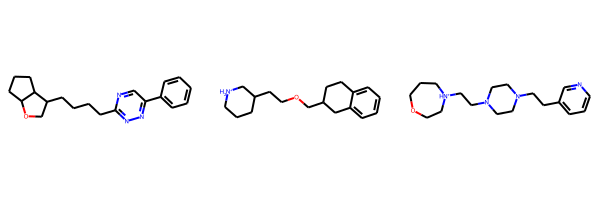

In [36]:
from rdkit import Chem
from rdkit.Chem import Draw

# convert the SMILES to RDKit Mol objects
molecules = [Chem.MolFromSmiles(s) for s in smiles]
# show the molecules
Draw.MolsToGridImage(molecules)

We see that the trained generative model is able to produce valid SMILES! Whether those particular SMILES are desirable or not is out of the scope of this notebook but it shows that training a generative model to **learn the underlying probability distribution of a SMILES dataset can yield a model that has learned the SMILES syntax and generate valid SMILES strings.**

The last topic to touch on is the `Negative Log-Likelihood` which is sometimes simply referred to as the `Likelihood`:

In [37]:
# print the negative log-likelihoods of the above 3 molecules
nlls

tensor([35.2345, 21.3279, 25.5417], grad_fn=<AddBackward0>)

### What Does The `Negative Log-Likelihood` Mean? 

Recall 3 things:

1. The `Negative Log-Likelihood` sums up all the probabilities of generating each token in the entire sequence


2. The `Log-Softmax Function` output was passed to the `Negative Log-Likelihood`


3. The `Log-Softmax Function` output is $[\infty, 0)$

This means a higher log probability of generating a token is closer to "0". **Thus, the smaller the `Negative Log-Likelihood` is, the greater probability the model has of generating that particular sequence**. In the above example, one can say that the model is more likely to generate molecules 2 and 3 compared to 1. **The `Negative Log-Likelihood` is sometimes expressed as the "`Likelihood` of generating a SMILES sequence".**

## Negative Log-Likelihood in Practical Applications

When using a molecular generative model, one would want proposed SMILES to be ***desirable***, i.e., satisfy a multitude of properties. This is done in `REINVENT` via `Reinforcement Learning (RL)` which is out of the scope of this notebook for the time being. However, another popular method is `Fine-Tuning` or `Transfer Learning` whereby one takes a trained model which has learned the SMILES syntax and **further trains it to bias the `Negative Log-Likelihoods` toward a smaller dataset of SMILES (fine-tuning dataset). This smaller dataset typically contains SMILES that are known to be desirable, e.g., possesses known potency, and the objective may be to propose new SMILES that are similar to these.** One can show using the `Negative Log-Likelihood` that `Fine-Tuning` or `Transfer Learning` does indeed lower the `Negative Log-Likelihood` of generating SMILES/similar SMILES to the fine-tuning dataset. For a concrete literature example of this, see **Fig. 1** in the following paper: https://link.springer.com/article/10.1007/s10822-021-00392-8